In [1]:
import sys

sys.path.insert(0, "../")

from mdu.eval.eval_utils import load_pickle
import numpy as np
from collections import defaultdict
from mdu.data.constants import DatasetName
from mdu.unc.constants import UncertaintyType
from mdu.unc.risk_metrics.constants import GName, RiskType, ApproximationType
from sklearn.metrics import roc_auc_score
from mdu.data.data_utils import split_dataset_indices
from mdu.unc.multidimensional_uncertainty import MultiDimensionalUncertainty
from mdu.unc.constants import VectorQuantileModel
import torch
import pandas as pd
from configs.uncertainty_measures_configs import (
    MAHALANOBIS_AND_BAYES_RISK,
    ADDITIVE_TOTALS,
    ADDITIVE_TOTALS_1_2,
    EXCESSES_DIFFERENT_INSTANTIATIONS,
    EXCESSES_DIFFERENT_APPROXIMATIONS_LOGSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE,
    BAYES_DIFFERENT_APPROXIMATIONS_LOGSCORE,
    BAYES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE,
    BAYES_DIFFERENT_INSTANTIATIONS,
)
from mdu.randomness import set_all_seeds

/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
UNCERTAINTY_MEASURES = (
    EXCESSES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE
    + BAYES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE
    + ADDITIVE_TOTALS
)
MULTIDIM_MODEL = VectorQuantileModel.ENTROPIC_OT
device = torch.device("cuda:0")

if MULTIDIM_MODEL == VectorQuantileModel.CPFLOW:
    train_kwargs = {
        "lr": 1e-4,
        "num_epochs": 10,
        "batch_size": 64,
        "device": device,
    }
    multidim_params = {
        "feature_dimension": len(UNCERTAINTY_MEASURES),
        "hidden_dim": 8,
        "num_hidden_layers": 5,
        "nblocks": 4,
        "zero_softplus": False,
        "softplus_type": "softplus",
        "symm_act_first": False,
    }

elif MULTIDIM_MODEL == VectorQuantileModel.OTCP:
    train_kwargs = {
        "batch_size": 64,
        "device": device,
    }
    multidim_params = {
        "positive": True,
    }
elif MULTIDIM_MODEL == VectorQuantileModel.ENTROPIC_OT:
    train_kwargs = {
        "batch_size": 64,
        "device": device,
    }
    multidim_params = {
        "target": "exp",
        "standardize": False,
        "fit_mse_params": False,
        "eps": 0.1,
        "max_iters": 100,
        "tol": 1e-6,
        "random_state": seed,
    }
else:
    raise ValueError(f"Invalid multidim model: {MULTIDIM_MODEL}")


ENSEMBLE_GROUPS = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
]

train_dataset = DatasetName.CIFAR10_NOISY.value
eval_dataset = DatasetName.CIFAR10.value
weights_root = "../model_weights"

In [3]:
set_all_seeds(seed)

results = defaultdict(list)

for group in ENSEMBLE_GROUPS:
    all_ind_logits = []
    for model_id in group:
        eval_res = load_pickle(
            f"{weights_root}/{train_dataset}/checkpoints/resnet18/CrossEntropy/{model_id}/{eval_dataset}.pkl"
        )

        logits_ind = eval_res["embeddings"]
        all_ind_logits.append(eval_res["embeddings"][None])

    y_true = eval_res["labels"]

    _, train_cond_idx, calib_idx, test_idx = split_dataset_indices(
        logits_ind,
        y_true,
        train_ratio=0.0,
        calib_ratio=0.1,
        test_ratio=0.8,
    )

    y_train_cond = y_true[train_cond_idx]
    y_calib = y_true[calib_idx]
    y_test = y_true[test_idx]

    X_train_cond = np.vstack(all_ind_logits)[:, train_cond_idx, :]
    X_calib = np.vstack(all_ind_logits)[:, calib_idx, :]
    X_test = np.vstack(all_ind_logits)[:, test_idx, :]

    y_pred = np.argmax(np.mean(X_test, axis=0), axis=-1)

    print(f"Ensemble accuracy: {np.mean(y_pred == y_test)}")

    multi_dim_uncertainty = MultiDimensionalUncertainty(
        UNCERTAINTY_MEASURES,
        multidim_model=MULTIDIM_MODEL,
        multidim_params=multidim_params,
        if_add_maximal_elements=True,
    )
    multi_dim_uncertainty.fit(
        logits_train=X_train_cond,
        y_train=y_train_cond,
        logits_calib=X_calib,
        train_kwargs=train_kwargs,
    )

    _, uncertainty_scores = multi_dim_uncertainty.predict(X_test)

All seeds have been set to 42
Ensemble accuracy: 0.8620833333333333


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.8205555555555556


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.7948611111111111


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.8052777777777778


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


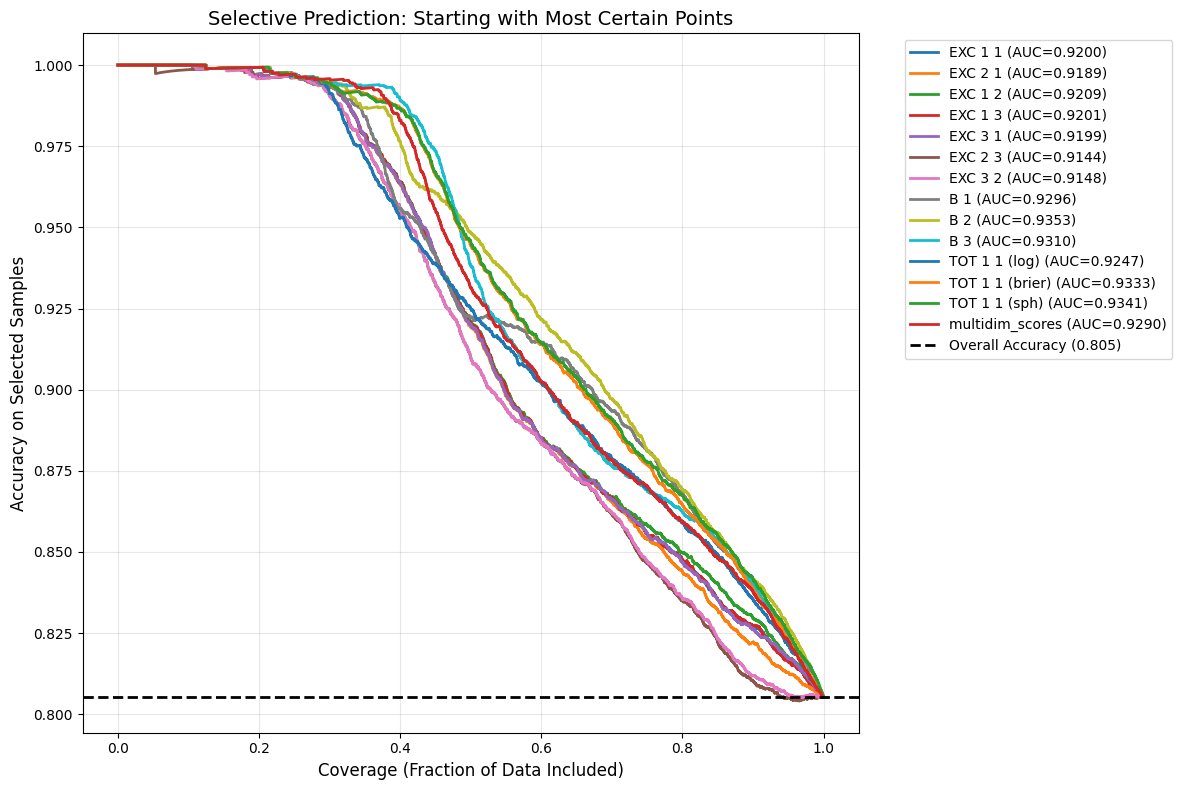


Area Under Curve (AUC) values for each method:
B 2: 0.935296
TOT 1 1 (sph): 0.934109
TOT 1 1 (brier): 0.933288
B 3: 0.931040
B 1: 0.929623
multidim_scores: 0.928975
TOT 1 1 (log): 0.924656
EXC 1 2: 0.920889
EXC 1 3: 0.920111
EXC 1 1: 0.920033
EXC 3 1: 0.919931
EXC 2 1: 0.918924
EXC 3 2: 0.914841
EXC 2 3: 0.914377


In [4]:
import matplotlib.pyplot as plt
from scipy import integrate

# Create selective prediction curves - starting with most certain points
plt.figure(figsize=(12, 8))

# Dictionary to store AUC values for each method
auc_values = {}

for measure_name, scores in uncertainty_scores.items():
    # Sort by uncertainty (ascending order - least to most uncertain)
    sorted_indices = np.argsort(scores)

    # Calculate accuracy as we progressively add more uncertain samples
    accuracies = []

    for i in range(1, len(sorted_indices) + 1):
        # Take the i most certain samples (first i samples in sorted order)
        selected_indices = sorted_indices[:i]

        # Calculate accuracy on these selected samples
        correct_predictions = np.sum(
            y_pred[selected_indices] == y_test[selected_indices]
        )
        accuracy = correct_predictions / i
        accuracies.append(accuracy)

    # Calculate coverage (fraction of data included so far)
    coverage = np.arange(1, len(scores) + 1) / len(scores)

    # Calculate area under the curve using trapezoidal rule
    auc = np.trapezoid(accuracies, coverage)
    auc_values[measure_name] = auc

    # Plot the selective prediction curve with AUC in label
    plt.plot(coverage, accuracies, label=f"{measure_name} (AUC={auc:.4f})", linewidth=2)

# Add baseline (overall accuracy)
overall_accuracy = np.mean(y_pred == y_test)
plt.axhline(
    y=overall_accuracy,
    color="black",
    linestyle="--",
    label=f"Overall Accuracy ({overall_accuracy:.3f})",
    linewidth=2,
)

plt.xlabel("Coverage (Fraction of Data Included)", fontsize=12)
plt.ylabel("Accuracy on Selected Samples", fontsize=12)
plt.title("Selective Prediction: Starting with Most Certain Points", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC values for quantitative comparison
print("\nArea Under Curve (AUC) values for each method:")
for method, auc in sorted(auc_values.items(), key=lambda x: x[1], reverse=True):
    print(f"{method}: {auc:.6f}")

/tmp/ipykernel_721902/2370215706.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aurc = np.trapz(risk, cov)             # lower is better
/tmp/ipykernel_721902/2370215706.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aurc = np.trapz(risk, cov)             # lower is better
/tmp/ipykernel_721902/2370215706.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aurc = np.trapz(risk, cov)             # lower is better
/tmp/ipykernel_721902/2370215706.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aurc = np.trapz(risk, cov)             # lower is better
/tmp/ipykernel_721902/2370215706.py:24: DeprecationWarning: 

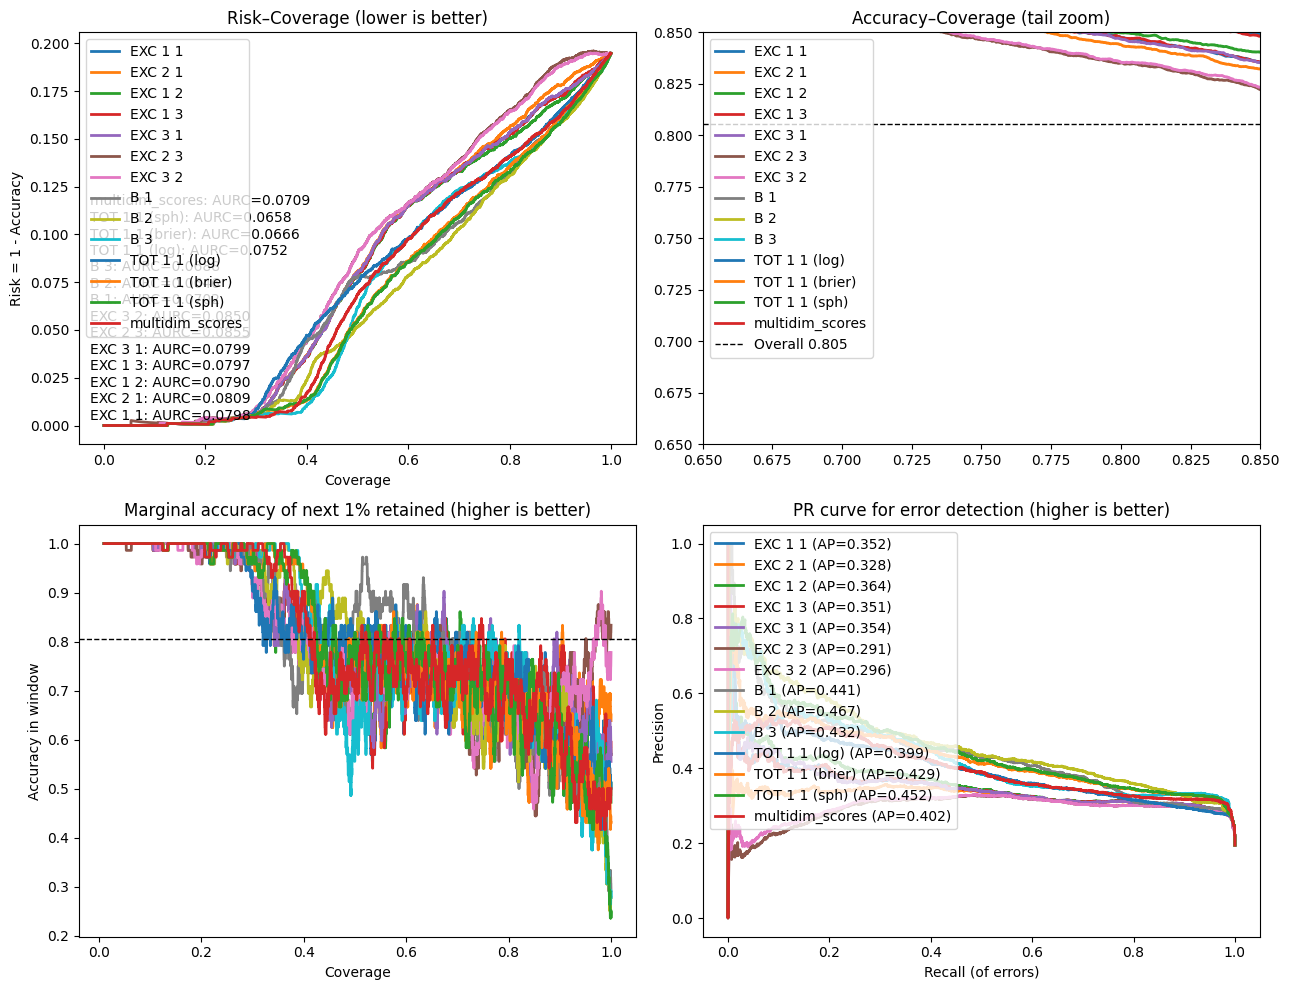

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


def selective_stats(scores, y_pred, y_true):
    n = len(scores)
    order = np.argsort(scores)  # low-uncertainty first
    correct = (y_pred == y_true).astype(int)[order]
    cov = np.arange(1, n + 1) / n
    acc = np.cumsum(correct) / np.arange(1, n + 1)
    risk = 1.0 - acc
    return cov, acc, risk, correct


overall_acc = np.mean(y_pred == y_test)

fig, axs = plt.subplots(2, 2, figsize=(13, 10))
ax_rc, ax_tail, ax_marg, ax_pr = axs.ravel()

for name, scores in uncertainty_scores.items():
    cov, acc, risk, correct_sorted = selective_stats(scores, y_pred, y_test)

    # 1) Risk–Coverage + AURC
    ax_rc.plot(cov, risk, lw=2, label=name)
    aurc = np.trapz(risk, cov)  # lower is better
    ax_rc.text(
        0.02,
        0.02 + 0.04 * len(ax_rc.lines),
        f"{name}: AURC={aurc:.4f}",
        transform=ax_rc.transAxes,
    )

    # 2) Tail zoom of Accuracy–Coverage
    ax_tail.plot(cov, acc, lw=2, label=name)

    # 3) Marginal accuracy of the next 1% (window)
    k = max(1, len(correct_sorted) // 100)  # 1% bins
    window = np.convolve(correct_sorted, np.ones(k, dtype=int), "valid") / k
    m_cov = np.linspace(k / len(correct_sorted), 1.0, len(window))
    ax_marg.plot(m_cov, window, lw=2, label=name)

    # 4) Error-detection PR (positives = errors; higher score = more error-like)
    errors = 1 - (y_pred == y_test).astype(int)
    prec, rec, _ = precision_recall_curve(
        errors, scores
    )  # scores↑ ⇒ more uncertain ⇒ more likely error
    ap = average_precision_score(errors, scores)
    ax_pr.plot(rec, prec, lw=2, label=f"{name} (AP={ap:.3f})")

# Formatting
# RC
ax_rc.set_title("Risk–Coverage (lower is better)")
ax_rc.set_xlabel("Coverage")
ax_rc.set_ylabel("Risk = 1 - Accuracy")
ax_rc.legend()

# Tail zoom
ax_tail.set_title("Accuracy–Coverage (tail zoom)")
ax_tail.set_xlim(0.65, 0.85)  # focus where curves diverge
ax_tail.set_ylim(0.65, 0.85)  # tighten y-range
ax_tail.axhline(overall_acc, ls="--", c="k", lw=1, label=f"Overall {overall_acc:.3f}")
ax_tail.legend()

# Marginal accuracy
ax_marg.set_title("Marginal accuracy of next 1% retained (higher is better)")
ax_marg.set_xlabel("Coverage")
ax_marg.set_ylabel("Accuracy in window")
ax_marg.axhline(overall_acc, ls="--", c="k", lw=1)

# PR for error detection
ax_pr.set_title("PR curve for error detection (higher is better)")
ax_pr.set_xlabel("Recall (of errors)")
ax_pr.set_ylabel("Precision")
ax_pr.legend()

plt.tight_layout()
plt.show()

In [6]:
def coverage_at_risk(cov, acc, risk_target=0.01):
    ok = acc >= (1.0 - risk_target)
    return cov[ok].max() if ok.any() else 0.0


targets = [0.01, 0.02, 0.05]  # 1%, 2%, 5% error
for name, scores in uncertainty_scores.items():
    cov, acc, risk, _ = selective_stats(scores, y_pred, y_test)
    vals = [coverage_at_risk(cov, acc, t) for t in targets]
    print(
        name,
        "Coverage@",
        {f"{int(100 * t)}%err": f"{v:.3f}" for t, v in zip(targets, vals)},
    )

EXC 1 1 Coverage@ {'1%err': '0.319', '2%err': '0.343', '5%err': '0.431'}
EXC 2 1 Coverage@ {'1%err': '0.318', '2%err': '0.344', '5%err': '0.434'}
EXC 1 2 Coverage@ {'1%err': '0.320', '2%err': '0.344', '5%err': '0.432'}
EXC 1 3 Coverage@ {'1%err': '0.320', '2%err': '0.344', '5%err': '0.431'}
EXC 3 1 Coverage@ {'1%err': '0.318', '2%err': '0.344', '5%err': '0.434'}
EXC 2 3 Coverage@ {'1%err': '0.302', '2%err': '0.337', '5%err': '0.415'}
EXC 3 2 Coverage@ {'1%err': '0.302', '2%err': '0.337', '5%err': '0.415'}
B 1 Coverage@ {'1%err': '0.322', '2%err': '0.358', '5%err': '0.429'}
B 2 Coverage@ {'1%err': '0.334', '2%err': '0.392', '5%err': '0.495'}
B 3 Coverage@ {'1%err': '0.399', '2%err': '0.432', '5%err': '0.484'}
TOT 1 1 (log) Coverage@ {'1%err': '0.306', '2%err': '0.326', '5%err': '0.410'}
TOT 1 1 (brier) Coverage@ {'1%err': '0.364', '2%err': '0.422', '5%err': '0.484'}
TOT 1 1 (sph) Coverage@ {'1%err': '0.358', '2%err': '0.424', '5%err': '0.486'}
multidim_scores Coverage@ {'1%err': '0.377'